# Generate MP snapshots for FOM and iFOM
A simple solid reactor model considering neutronics and thermal diffusion will be used to generate snapshots, using a true coupling between neutronics and thermal diffusion (FOM) and a weakly coupled approach (iFOM).

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt

path_snaps = '../../../Data/TWIGL2D/'
os.makedirs(path_snaps, exist_ok=True)

The diffusion coefficient and the absorption cross section are assumed to have the following form:

\begin{equation}
    \begin{split}
        f_{D} &= D^{\text{ref}}_g\cdot \left[1+\gamma_{D_g}\cdot \sin\left(2.75\cdot \frac{T-T^{\text{ref}}}{T^{\text{ref}}}\right)\right]\\
        f_{a} &= \Sigma_{a,g}^{\text{ref}}\cdot \left[1+\gamma_{\Sigma_{a,g}}\cdot \tanh\left(2\cdot \frac{T-T^{\text{ref}}}{T^{\text{ref}}}\right) \right]
    \end{split}
\end{equation}

And their linearized forms around a reference temperature $T^{\text{ref}}$:
\begin{equation}
    \left\{
        \begin{aligned}
            f_D\left(T;\,T^{\text{ref}}, D_g^{\text{ref}},\boldsymbol{\gamma}_D\right) &\approx m_{D_g}\cdot T + q_{D_g} \\
            f_a\left(T;\,T^{\text{ref}}, \Sigma_{a,g}^{\text{ref}},\boldsymbol{\gamma}_a\right) &\approx m_{\Sigma_{a,g}}\cdot T+ q_{\Sigma_{a,g}}\\
        \end{aligned}
    \right.
\end{equation}

In [2]:
from sklearn.linear_model import LinearRegression

# Coupling coefficients
gammas = [2e-2, 2e-2, 4e-2, 4e-2]

T_ref = 600
T = np.linspace(600, 1200, 20).reshape(-1,1)

coupling = [
            lambda T: 1  + gammas[0] * np.sin(2.75*(T-T_ref)/T_ref),
            lambda T: 1  + gammas[2] * np.tanh(2*(T-T_ref)/T_ref)
            ]

ranges = [[1, 1.025], [1, 1.05]]
coupl_labels = ['Root', r'$\log$', r'$\sin$', r'$\tanh$']
coupl_ylab = [r'Diffusion function $f_D$',r'Absorption function $f_a$']

model = [LinearRegression().fit(T, coupling[ii](T)) for ii in range(len(coupling))]

print('Model f_D: y = {:.4e}'.format(model[0].intercept_[0])+' + {:.4e}'.format(model[0].coef_[0][0])+' * x')
print('Model S_a: y = {:.4e}'.format(model[1].intercept_[0])+' + {:.4e}'.format(model[1].coef_[0][0])+' * x')

Model f_D: y = 1.0005e+00 + 1.4384e-05 * x
Model S_a: y = 9.7015e-01 + 6.2195e-05 * x


Let us plot the diffusion coefficient and the absorption cross section as a function of temperature, and their linearized forms around a reference temperature $T^{\text{ref}}$.

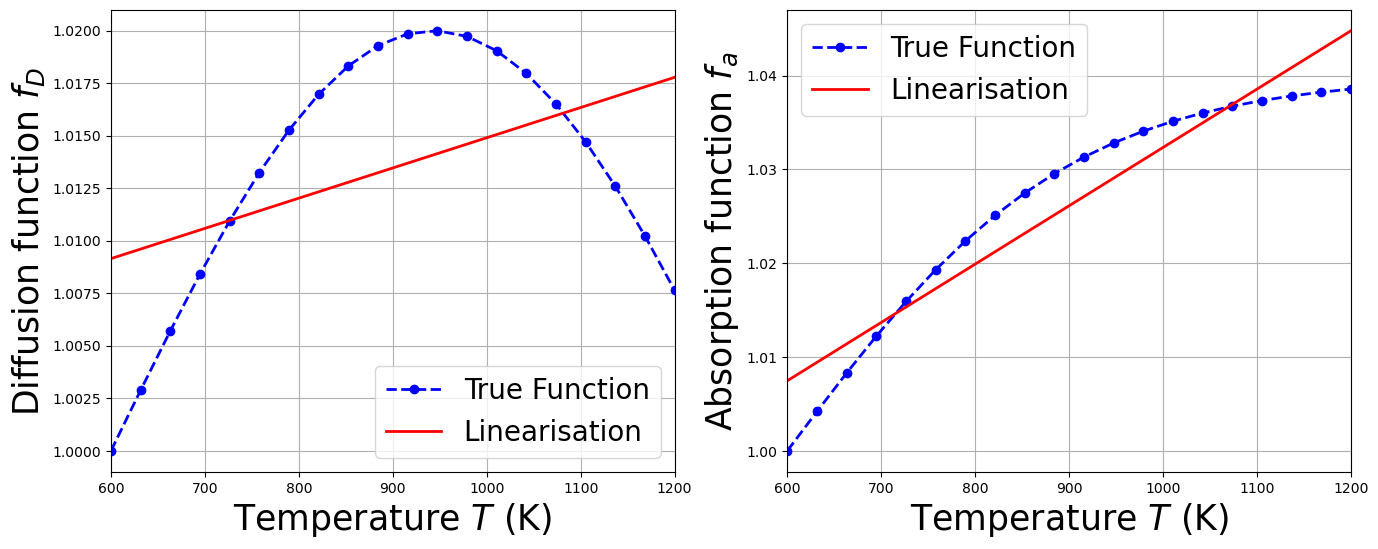

In [3]:
fig, axs = plt.subplots(1, len(coupling), figsize=(8 * len(coupling), 6))

axs[0].plot(T, coupling[0](T), 'b--o', label=r'True Function', linewidth=2)
axs[0].plot(T, model[0].intercept_ + model[0].coef_ * T, 'r-', label=r'Linearisation', linewidth=2)

axs[1].plot(T, coupling[1](T), 'b--o', label=r'True Function', linewidth=2)
axs[1].plot(T, model[1].intercept_ + model[1].coef_ * T, 'r-', label=r'Linearisation', linewidth=2)

axs[0].set_ylabel(coupl_ylab[0], fontsize=25)
axs[1].set_ylabel(coupl_ylab[1], fontsize=25)

for ax in axs:
    ax.set_xlabel(r'Temperature $T$ (K)', fontsize=25)
    ax.set_xlim([600, 1200])
    ax.legend(fontsize=20)
    ax.grid(True)

Let us define a function able to extract the coupling coefficients in a dict format for the solver

In [4]:
def get_coupling_dict(gammas, mode):
    coupling = [lambda T: 1  + gammas[0] * np.sin(2.75*(T-T_ref)/T_ref),
                lambda T: 1  + gammas[1] * np.sin(2.75*(T-T_ref)/T_ref),
                lambda T: 1  + gammas[2] * np.tanh(2*(T-T_ref)/T_ref),
                lambda T: 1  + gammas[3] * np.tanh(2*(T-T_ref)/T_ref)]
    coupl_labels = [r'$D_1$', r'$D_2$', r'$\Sigma_{a,1}$', r'$\Sigma_{a,2}$']

    model = [LinearRegression().fit(T, coupling[ii](T)) for ii in range(len(coupling))]

    coupling_dict = dict()
    coupling_dict['mode'] = mode
    coupling_dict['T_ref'] = T_ref

    if coupling_dict['mode'] == 'linear':
        coupling_dict['intercept'] = list()
        coupling_dict['slope']     = list()
        for ii in range(len(coupling)):
            coupling_dict['intercept'].append( model[ii].intercept_[0] )
            coupling_dict['slope'].append( model[ii].coef_[0][0] )
    else:
        coupling_dict['gammas'] = gammas
        
    return coupling_dict

D_1_parameters = np.linspace(0.5, 2, 25) # parameter space
coupling_dict = {
    'FOM': get_coupling_dict(gammas, 'True'),
    'iFOM': get_coupling_dict(gammas, 'linear')
}

finalT = {
    'FOM': 2,
    'iFOM': 1
}

from models.fullyMP import generate_mp_data
from IPython.display import clear_output as clc
import warnings
warnings.filterwarnings("ignore")

for model in coupling_dict.keys():
    for ii, D_1 in enumerate(D_1_parameters):
        case_path = os.path.join(path_snaps, model, f'D1_{ii+1}')
        os.makedirs(case_path, exist_ok=True)

        generate_mp_data(case_path, coupling = coupling_dict[model], 
                         D1_reg1=D_1, finalT = finalT[model], 
                         dt_save=0.02)
        clc()